
#Aclaraciones de librerias

*   Numpy 1.12.1
*   scikit-learn 0.18.1
*   Elemento de la lista
*   Matplotlib 2.0.2
*   Pandas 0.20.1




#Habilitando google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# instalar librería para visualizar el progreso de ejecución una tarea en background
!pip install pyprind

#Importando librerias

In [4]:
import xml.etree.ElementTree as etree
import csv
from os import scandir
from sklearn.model_selection import train_test_split

In [6]:
import os 
#listado_de_archivos_desde_un_path
def files_of_path(path): 
    return [obj.name for obj in os.scandir(path) if obj.is_file()]
    
files= files_of_path("/content/drive/MyDrive/AI/datasets/Corpus/Spanish/tass_2017")
for file in files:
    print(file)

#función para convertir listas en archivos CSV

In [7]:
def list_to_csv(data, filename):
  with open(filename, 'w', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', lineterminator='\n', quoting=csv.QUOTE_NONNUMERIC)
    writer.writerows(data)

#función para cargar de un CSV a una LISTA (messages | labels)

In [8]:
def csv_to_lists(filename):
  messages = []
  labels = []
  with open(filename, 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      messages.append(row[1])
      labels.append(row[2])
  return messages, labels

#funciones para prasear xml en un dataframe

##corpus de general tweetid | content | sentiments/polarity/value

In [9]:
def general_tass_to_list(filename):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = tweet.find('sentiments/polarity/value').text
    data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

In [10]:
def general_tass_2017_to_list(filename,qrel=None):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = qrel[tweetId]
    data.append([tweetId, content.replace('\n',' '), polarityValue])

  return data

##Corpus politics tweetid | content | sentiments/polarity

In [11]:
def politics_tass_to_list(filename):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    aux = next((e for e in tweet.findall('sentiments/polarity') if e.find('entity') == None), None)
    if aux != None:
      polarityValue = aux.find('value').text
      data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

##corpus de internacional tweetid | content | sentiments/polarity/value

In [12]:
def intertass_tass_to_list(filename, qrel=None):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = tweet.find('sentiment/polarity/value').text
    if polarityValue == None:
      polarityValue = qrel[tweetId]
      data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

##funcion para unir los tweets corpus general test con sus sentimientos

In [13]:
def gold_standard_to_dict(filename):
  with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    data = {rows[0]: rows[1] for rows in reader}

  return data

#Función para separar el 100% del corpus entre Train(70%) y Test(30%)

In [14]:
def generate_train_test_subsets(data, size):
     codes = [d[0] for d in data]
     labels = [d[2] for d in data]
     codes_train, codes_test, labels_train, label_test = train_test_split(codes, labels, train_size=size)
     train_data = [d for d in data if d[0] in codes_train]
     test_data = [d for d in data if d[0] in codes_test]
     return train_data, test_data

#Ejecutar cada función de parsear los copus y guardarlo en un CSV(full, train, test)

In [15]:
data = []

##Tomamos el corpus internacional (test) y generamos una lista de ID del tweet y el sentimiento para agregarlo a la data

In [17]:
qrel = gold_standard_to_dict('/content/drive/MyDrive/AI/datasets/Corpus/Spanish/tass_2017/InterTASS/InterTASS_Test_res.qrel')

Como el test del corpus internacional esta sin los sentimientos, es necesario agregarlos

In [18]:
data.extend(intertass_tass_to_list(
    '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/tass_2017/InterTASS/InterTASS_Test.xml', 
    qrel
))

data.extend(intertass_tass_to_list(
    '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/tass_2017/InterTASS/InterTASS_development.xml'
))

data.extend(intertass_tass_to_list(
    '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/tass_2017/InterTASS/InterTASS_Training.xml'   
))

##Parceamos el general TASS

In [19]:
qrel = gold_standard_to_dict('/content/drive/MyDrive/AI/datasets/Corpus/Spanish/tass_2017/General Corpus of TASS/general-sentiment-3l.qrel')

In [20]:
data.extend(general_tass_2017_to_list(
    '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/tass_2017/General Corpus of TASS/general-tweets-test.xml',
    qrel
))


##Parceamos el STOMPOL (política) TASS_2014

In [21]:
data.extend(politics_tass_to_list(
    '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/tass_2014/politics-test-tagged.xml'
))

##Separamos la data en Train y Test

In [24]:
train, test = (generate_train_test_subsets(data, size=0.3))

In [25]:
list_to_csv(data, '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/dataset_2017_full.csv')
list_to_csv(train, '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/dataset_2017_train.csv')
list_to_csv(test, '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/dataset_2017_test.csv')

#Preprocesamiento del corpus

##Cargar librerías necesarias

In [26]:
import re
from nltk import TweetTokenizer
from nltk.stem import SnowballStemmer

Varaibles para mejorar la escritura (opcional)

In [27]:
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'twlaugh'


Definir que el algortimo de clasificación use el idimoa español

In [28]:
_stemmer = SnowballStemmer('spanish')

Definir una variable para la funcipon de tokenizar (opcional)

In [29]:
_tokenizer = TweetTokenizer().tokenize

Variable para definir si quiero normalizar o eliminar: remove los hashtag, menciones y urls en los tweets

In [31]:
_twitter_features = 'normalize'

Variable para definir si se desea convertir o no a la raiz de la palabra

In [32]:
_stemming = False

##Funciones / métodos de preprocesamiento

Listas de Conversión (Quitar tildes y palabras coloquiales)
Lista de conversión para quitar las tildes a las vocales

In [33]:
DIACRITICAL_VOWELS = [('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ü', 'u')]

Lista para corregir algunas palabras coloquiales / jerga en español (palabras básicas)

In [34]:
SLANG = [('d', 'de'), ('(q|k)', 'que'), ('[qk]', 'que'), ('xo', 'pero'), ('xa', 'para'), 
         ('[xq]', 'porque'), ('fvr', 'favor'), ('(xfa|xf|pf|plis|pls|porfa)', 'por favor'),
         ('dnd', 'donde'), ('tb', 'tambien'), ('(tq|tk)', 'te quiero'), ('tqm', 'te quiero mucho'),
         ('x', 'por'), ('\+', 'mas'), ('maso', 'mas o menos'), ('(holi|hl)', 'hola'), 
         ('wnas', 'buenas'), ('nd', 'nada'), ('msj', 'mensaje'), ('es3', 'estre'), ('tp', 'tampoco'), 
         ('(wno|weno|bn)', 'bueno'), ('DM', 'mensaje directo'), ('BFF', 'mejores amigos para siempre'),
         ('OMG', 'Oh Dios mio'), ('TBT', 'jueves de vuelta al pasado')]

Función / método de normalización de risas

In [35]:
def normalize_laughs(message):
    message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
    message = re.sub(r'\b(?=\w*[k])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
    message = re.sub(r'\b(?=\w*[h])[aeiouh]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
    message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
    return message

In [36]:
print(normalize_laughs('jajaja, jejeje, Lol, hohoho, kokoko'))

twlaugh, twlaugh, twlaugh, twlaugh, twlaugh


Función / método para eliminar o normalizar menciones, hashtags y URL de un mensaje (tweet)

In [38]:
def process_twiter_features(message, twitter_features):
    message = re.sub(r'[\.\,]http', '. http', message, flags=re.IGNORECASE)
    message = re.sub(r'[\.\,]#', '. #', message)
    message = re.sub(r'[\.\,]@', '. @', message)
    if twitter_features == REMOVE:
        # Eliminar menciones, hashtags y URL
        message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
        message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
    elif twitter_features == NORMALIZE:
        # Cuando sea necesario se normalizaran las menciones, hashtags y URL
        message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
        message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
        message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)
    return message

In [119]:
print(process_twiter_features('@MarvelStudios, #MarvelStudios, https://marvelstudios.com', 'normalize'))

twmention twhashtag twurl


Función / método general para el preprocesamiento

In [40]:
def preprocess(message):
    message = message.lower()

    # Eliminar números, retorno de línea y los retweet(antiguos estilos de twitter)
    message = re.sub(r'(\d+|\n|\brt\b)', '', message)

    # Eliminar vocales con signos diacríticos (posibles ambigüedades)
    for s,t in DIACRITICAL_VOWELS:
        message = re.sub(r'{0}'.format(s), t, message)

    # Eliminar caracteres repetidos
    message = re.sub(r'(.)\1{2,}', r'\1\1', message)
    
    # Normalizar las risas
    message = normalize_laughs(message)

    # Traducir la jerga y terminos coloquiales sobre todo en el español
    for s,t in SLANG:
        message = re.sub(r'\b{0}\b'.format(s), t, message)
    
    # Normalizar - eliminar hashtags, menciones y URL
    message = process_twiter_features(message, _twitter_features)

    # Convertir las palabras a su raiz (Bonito, Bonita --> bonit)
    if _stemming: 
        message = ' '.join(_stemer.stem(w) for w in _tokenizer(message))

    return message

In [44]:
print(preprocess("jajaja, @fabianr8a"))

twlaugh, twmention


##**Descargar las librerías NLTK**

Descargamos la librería de stopwords

In [42]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#**Cargamos el CSV del corpus**

##Cargamos el CSV del corpus

In [45]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/AI/datasets/Corpus/Spanish/dataset_2017_full.csv', encoding='utf-8')

Asignamos nombres a las columnas del csv para facilitar la búsqueda de información

In [46]:
df.columns = ['tweetid', 'tweet', 'sentiment']

Aplicamos el preprocesamiento a los tweets con steaming = False

In [47]:
df['tweet'] = df['tweet'].apply(preprocess)

Eliminamos la columna tweetid que no nos sirve para entrenar y si genera más uso de memoria

In [48]:
df = df.drop(columns='tweetid')

Es mejor trabajar con valores enteros que con letras, por lo tanto reemplazaremos los sentimientos

In [49]:
df.loc[df['sentiment'] == 'NONE', 'sentiment'] = '-1'
df.loc[df['sentiment'] == 'NEU', 'sentiment'] = '0'
df.loc[df['sentiment'] == 'P', 'sentiment'] = '1'
df.loc[df['sentiment'] == 'N', 'sentiment'] = '2'
df['sentiment'].unique()

array(['1', '2', '-1', '0'], dtype=object)

Guardamos el dataset en un nuevo CSV para facilitar su posterior uso

In [50]:
df.to_csv(
    '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/dataset_2014_full_clean.csv', 
    index=False, 
    encoding='utf-8')

#**Entrenar el modelo de aprendizaje**

##**Funciones para tokenizar y extraer tweets**

**Función para tokenizar y limpiar**

In [51]:
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

**Función para extraer un documento del dataset**

In [52]:
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)       # Skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

**Función que tomara una secuencia de documentos y devolvera un número particular de documentos**

In [53]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [55]:
next(stream_docs(path='/content/drive/MyDrive/AI/datasets/Corpus/Spanish/dataset_2014_full_clean.csv'))

('twmention ya era hora de volver al csgo y dejares el padel bienvenida ', 1)

#**Entrenamos el modelo con regresión logística**

In [72]:
path = '/content/drive/MyDrive/AI/datasets/Corpus/Spanish/dataset_2017_full_clean.csv'

Definimos una versión liviana de CountVectorizer + TfidfVectorizer llamada HashingVectorizer

In [73]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

In [74]:
vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer)

Definimos como algoritmo la regresión logística en el descenso gradiente

In [75]:
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path)

In [76]:
import re
import numpy as np

Entrenamiento

In [77]:
from nltk.corpus import stopwords
stop = stopwords.words('spanish')

Definimos las clases con las cuales vamos a entrenar

In [78]:
classes = np.array([-1, 0, 1, 2])

In [81]:
##pbar = pyprind.ProgBar(50)

for _ in range(50):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    ##pbar.update()

Probamos la eficiencia del modelo con 5000 tweets

In [82]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)

In [83]:
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.812


Recalibramos el modelo

In [84]:
clf = clf.partial_fit(X_test, y_test)

#Serializamos / Congelamos el modelo para usarlo fuera de Google Colaboratory

Creamos una carpeta en el drive para guardar los archivos serializados

In [86]:
import pickle
dest = os.path.join('/content/drive/MyDrive/AI/datasets/Corpus/Spanish/TwitterClassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

Convertimos el clasificador y el stopword en archivo/objetos pkl. Es importante verificar que si se encuentran en dicho directorio

In [88]:
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

Para probar si funciona, cambiamos la basepath (directorio por defecto) de Python a la carpeta de TwitterClassifier

In [90]:
os.chdir('/content/drive/MyDrive/AI/datasets/Corpus/Spanish/TwitterClassifier')

Deserializamos los estimadores

In [92]:
clf = pickle.load(
    open(
        os.path.join('/content/drive/MyDrive/AI/datasets/Corpus/Spanish/TwitterClassifier/pkl_objects', 
                     'classifier.pkl'), 
         'rb'))

Clasifiquemos un texto de ejemplo

In [93]:
label = {-1:'Sin sentimientos', 0:'Neutro', 1:'Positivo', 2:'Negativo'}

In [96]:
frase = 'Estoy triste por la situacion actual del pais'
example = [frase]

Convertimos el texto en un vecot de palabras y extraemos sus caracteristicas https://scikit-learn.org/stable/modules/feature_extraction.html

In [97]:
textConvert = vect.transform(example)

print('Predicción: %s \nProbabilidad: %.2f%%' % (label[clf.predict(textConvert)[0]], np.max(clf.predict_proba(textConvert))*100))
print('Predicción: %s' % label[clf.predict(textConvert)[0]])
print(np.max(clf.predict_proba(textConvert))*100)

Predicción: Negativo 
Probabilidad: 60.73%
Predicción: Negativo
60.72737610475305


#**Recorremos los tweets descargados y los clasificamos**

In [108]:
import numpy as np
import pandas as pd
import pyprind

pbar = pyprind.ProgBar(50000)

df = pd.read_csv('/content/drive/MyDrive/AI/datasets/Corpus/Spanish/PNL/Copa_america/Copa_America_2021', encoding='utf-8')
#creamos una columna llamada Sentimient donde guardaremos la predicción
df['sentiment'] =''
#creamos una columna llamada Probability donde guardaremos la acertabilidad que dio el clasificador
df['probability']=0
#conversión de sentimientos (numeros a palabras)= NONE->-1 | NEU -> 0 | P->1 | N->2
label = {-1:'Sin sentimiento', 0:'Neutro', 1:'Positivo',2: 'Negativo'}
for rowid in range(len(df.index)):
  text=df['text'][rowid]
  textConvert = vect.transform([text]) 
  df['sentiment'][rowid]=label[clf.predict(textConvert)[0]]
  df['probability'][rowid]=np.max(clf.predict_proba(textConvert))*100
  pbar.update()
df.head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
0% [#                             ] 100% | ETA: 00:35:22

,user,location,text,sentiment,probability
0,BarryShirts,NaN,La #CopaAmerica2021 se juega en Chile?\n\nIG: ...,Positivo,67
1,renzorgamboa,NaN,Modo #CopaAmerica2021 activado https://t.co/Qc...,Positivo,67
2,Goyorozco,Valledupar - Colombia,Así nace la peor cepa! #PetroYaBasta #MuyParac...,Negativo,51
3,Trouman1977,NaN,@CONMEBOL debería mover toda la #CopaAmerica20...,Positivo,70
4,infogatecl,Santiago de Chile,⚽️🏆📢 #CopaAmerica2021 en medio de la #pandemi...,Positivo,47
5,infogatecl,Santiago de Chile,⚽️🏆El mundo civilizado se pregunta 📢 ¿Tiene se...,Positivo,66
6,cletero_ilustre,"Ñuñoa, Chile",Justo para hacer la #CopaAmerica2021 en #Chile...,Positivo,60
7,jonathanset67,"Viena, Austria",@LDanieri Pero quieren hacer la #CopaAmerica2021,Negativo,48
8,Chiky_Caballero,Buenos Aires,@BrasileiraoPlay @gabigol @Flamengo Felicitaci...,Positivo,67
9,alexanderemp,Stgo. Chile,@CHVNoticias Esta la media cga con el #COVID19...,Positivo,65


In [114]:
df.to_csv('/content/drive/MyDrive/AI/datasets/Corpus/Spanish/PNL/Copa_america/Copa_America_2021', index=False, encoding='utf-8')
print(df.head(5))

           user               location  ... sentiment probability
0   BarryShirts                    NaN  ...  Positivo          67
1  renzorgamboa                    NaN  ...  Positivo          67
2     Goyorozco  Valledupar - Colombia  ...  Negativo          51
3   Trouman1977                    NaN  ...  Positivo          70
4    infogatecl      Santiago de Chile  ...  Positivo          47

[5 rows x 5 columns]


Segunda forma de ejecutar el análisis (métodos)

In [115]:
#segunda forma de ejecutar el analisis (metodos)
def f_prediction(row):
  text=row['text']
  textConvert = vect.transform([text]) 
  return label[clf.predict(textConvert)[0]]

def f_probability(row):
  text=row['text']
  textConvert = vect.transform([text]) 
  return np.max(clf.predict_proba(textConvert))*100

df["sentiment"] = df.apply(f_prediction, axis=1) # recorriendo columnas
df["probability"] = df.apply(f_probability, axis=1) # recorriendo columnas

sentiment
Negativo     193
Positivo    2988
dtype: int64


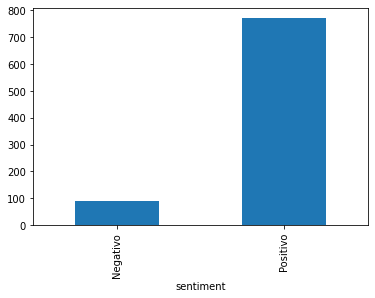

In [117]:
import matplotlib.pyplot as plt
df.groupby('sentiment')['location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
plt.show()
